/home/shibaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/shibaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


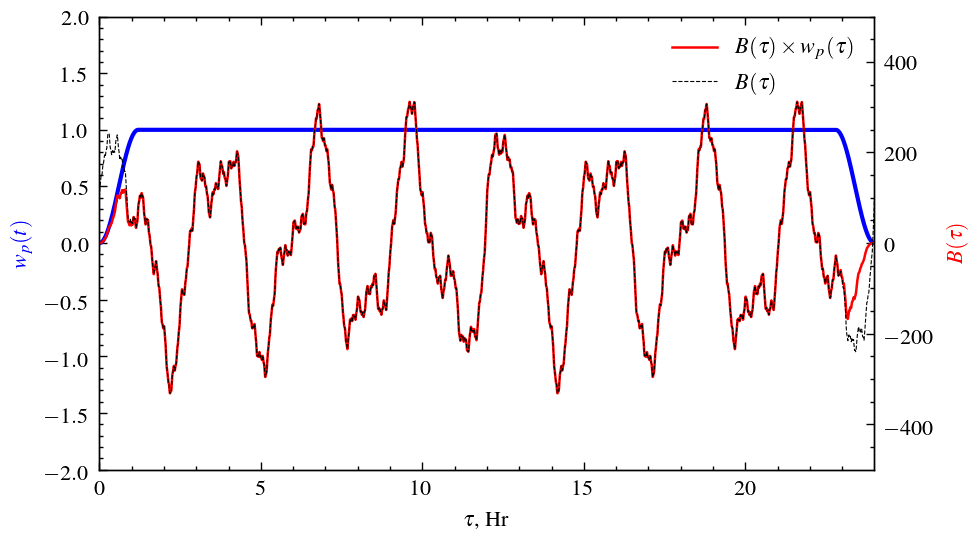

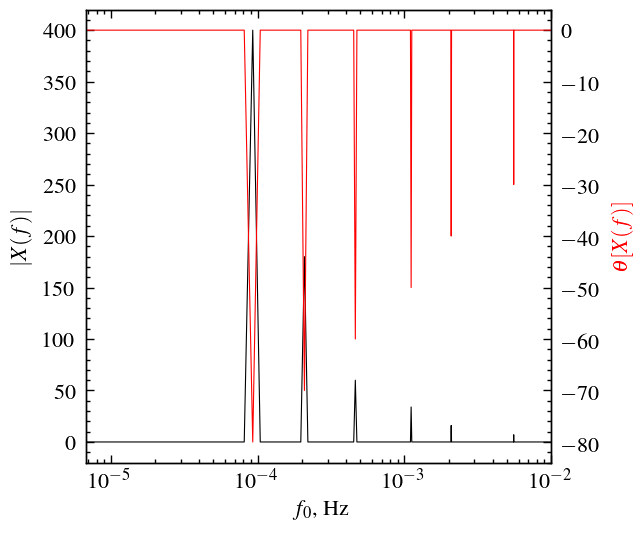

In [1]:
import matplotlib.pyplot as plt
plt.style.use(['science','ieee'])
import numpy as np
import pandas as pd
import scipy.fftpack
from scipy.stats import pearsonr

import models

## Regression check
def reg_check(analy, numerical, txt):
    fig, ax = plt.subplots(figsize=(3,3), dpi=200)
    ax.plot(analy, numerical, "ko", ms=0.2, alpha=0.4)
    ax.set_xlabel(r"$E^{anl}(t)$")
    ax.set_ylabel(r"$E^{fft}(t)$")
    ax.plot([0,1],[0,1], transform=ax.transAxes, color="r", ls="--", lw=0.8)
    r, _ = pearsonr(analy, numerical)
    ax.text(0.1, 0.9, r"$\rho=$%.10f"%r, va="center", ha="left", transform=ax.transAxes)
    ax.text(0.9, 0.1, txt, va="center", ha="right", transform=ax.transAxes)
    ax.set_xlim([-15,15])
    ax.set_ylim([-15,15])
    return r

## Tapering by split cosine bell window

def precond(x, tm, p=0.1, plot=True):
    T = len(tm)
    P, P2 = int(T*p), int(T*p/2)
    wp = np.zeros_like(x)
    wp[:P2] = 0.5*(1 - np.cos(2*np.pi*tm[:P2]/P))
    wp[P2:T-P2] = 1.
    wp[T-P2:] = 0.5*(1 - np.cos(2*np.pi*(tm[-1]-tm[T-P2:])/P))
    y = x*wp
    if plot:
        tx = tm/3600.
        fig, ax = plt.subplots(figsize=(5,3), dpi=200)
        ax.plot(tm/3600., wp, "b", lw=1.5)
        ax.set_ylabel(r"$w_p(t)$", color="b")
        ax.set_xlabel(r"$\tau$, Hr")
        ax.set_xlim(tx[0], tx[-1])
        ax.set_ylim(-2,2)
        ax = ax.twinx()
        ax.plot(tm/3600., y, "r", lw=0.9, label=r"$B(\tau)\times w_p(\tau)$")
        ax.plot(tm/3600., x, "k", lw=0.4, label=r"$B(\tau)$")
        ax.set_ylabel(r"$B(\tau)$", color="red")
        ax.legend(loc=1)
        ax.set_ylim(-500,500)
        ax.set_xlim(tx[0], tx[-1])
    return y

## Use fft block to create ifft.

def run_rfft_block(x, dT=1, plot=True):    
    Y = np.fft.rfft(x)
    f = np.fft.rfftfreq(len(x))/dT
    amplt = np.abs(Y)*2/len(Y)
    phase = np.angle(Y, deg=True)
    phase[np.abs(Y) < 1] = 0
    
    if plot:
        fig, ax = plt.subplots(figsize=(3,3), dpi=200)
        ax.semilogx(f, amplt, "k", lw=0.4)
        ax.set_xlim(0, 1e-2)
        ax.set_ylabel(r"$|X(f)|$")
        ax.set_xlabel(r"$f_0$, Hz")
        ax = ax.twinx()
        ax.semilogx(f, phase, "r", lw=0.4)
        ax.set_xlim(0, 1e-2)
        _ = ax.set_ylabel(r"$\theta[X(f)]$", color="r")
    return Y, f

# setup sample B Field data
Am = np.array([200, 90, 30, 17, 8, 3.5])
Phim = np.array([10, 20, 30, 40, 50, 60])
Tm = np.array([180, 80, 36, 15, 8, 3])*60
fm = 1./Tm
#fm = np.array([0.00009259, 0.00020833, 0.00047619, 0.00111111, 0.00238095, 0.00555555])
t = np.linspace(0,60*60*24,60*60*24,endpoint=False)

Bt = np.zeros(len(t))
for m in range(6):
    Bt += Am[m]*np.sin(2*np.pi*fm[m]*t + np.deg2rad(Phim[m]))

def draw_table(qx, f):
    Kfm = qx.calcZ(layer="floor", freqs=f)
    o = pd.DataFrame()
    o["fm (Hz)"], o["Amplitude |Km| (mV/km/nT)"], o["Phase, tm, (deg)"] = fm, np.absolute(Kfm), np.rad2deg(np.angle(Kfm))
    o.index.name = "m"
    return o.copy()

precond(Bt, t)
Bf, frq = run_rfft_block(Bt, t[1]-t[0])
# Check table-1 
dat, fs = [], []
for f in fm:
    i = np.argmin(abs(f-frq))
    fs.append(frq[i])
    dat.append(Bf[i])
#print(np.angle(dat, deg=True))

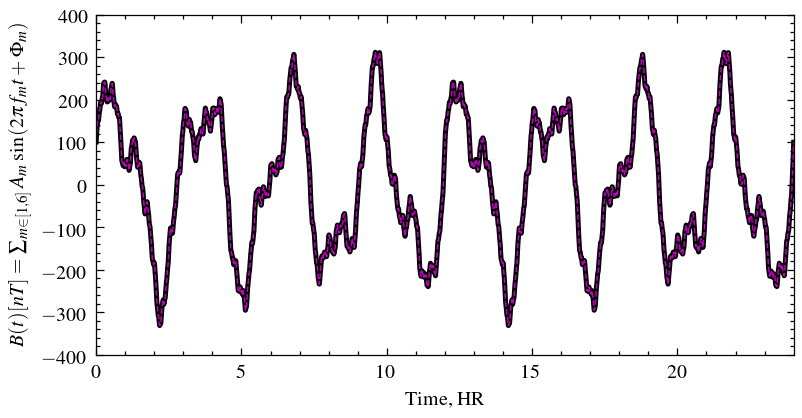

In [2]:
t0 = t/3600.
fig = plt.figure(dpi=180, figsize=(5, 2.5))
ax = fig.add_subplot(111)
ax.plot(t0, Bt, "k", lw=2)
ax.plot(t0, np.fft.irfft(Bf), "m", lw=0.6, ls="--")
ax.set_ylabel(r"$B(t)[nT]=\sum_{m\in[1,6]}A_m\sin{(2\pi f_mt+\Phi_m)}$")
ax.set_xlim(0, t0[-1])
ax.set_xlabel("Time, HR")
_ = ax.set_ylim(-400,400)

In [3]:
# Convert uniform Earth model
omu = models.OceanModel()
omu.site.resistivities[:] = 10
ou = draw_table(omu, fm)
print(ou)

# Layered Quebec model
om = models.OceanModel(model_name="DB1")
o = draw_table(om, fm)
print(o)

# Convert uniform Earth model
tfu = omu.get_TFs(freqs=fm)
tfu["Amplitude (mV/km/nT)"], tfu["Phase, tm, (deg)"] = np.absolute(tfu.Ef2Bs), np.rad2deg(np.angle(tfu.Ef2Bs))
tfu = tfu.rename(columns={"freq":"fm (Hz)"}).drop(columns=["Ef2Bs"])
print(tfu)

# Layered Quebec model
tf = om.get_TFs(freqs=fm)
tf["Amplitude (mV/km/nT)"], tf["Phase, tm, (deg)"] = np.absolute(tf.Ef2Bs), np.rad2deg(np.angle(tf.Ef2Bs))
tf = tf.rename(columns={"freq":"fm (Hz)"}).drop(columns=["Ef2Bs"])
print(tf)

    fm (Hz)  Amplitude |Km| (mV/km/nT)  Phase, tm, (deg)
m                                                       
0  0.000093                   0.068041              45.0
1  0.000208                   0.102062              45.0
2  0.000463                   0.152145              45.0
3  0.001111                   0.235702              45.0
4  0.002083                   0.322749              45.0
5  0.005556                   0.527046              45.0
    fm (Hz)  Amplitude |Km| (mV/km/nT)  Phase, tm, (deg)
m                                                       
0  0.000093                   0.218837         77.148343
1  0.000208                   0.448036         73.761121
2  0.000463                   0.850302         67.408604
3  0.001111                   1.539197         62.080705
4  0.002083                   2.358530         60.923240
5  0.005556                   4.662468         54.969917
    fm (Hz)  Amplitude (mV/km/nT)  Phase, tm, (deg)
0  0.000093              0.026889   

In [7]:
from scipy.fft import fft, fftfreq, ifft

def create_fft_frame(signal_a):
    n = int(len(signal_a))
    signal_a_freq = 2.0/n * np.fft.rfft(signal_a)
    fstep = 1 / n
    frq = np.arange(len(signal_a_freq)) * fstep
    frq[0] = frq[1]
    return signal_a_freq, frq

def calculate_electric_field(Bt, ox):
    signal_freq, frq = run_rfft_block(Bt)
    frq[0] = frq[1]
    t = ox.get_TFs(freqs=frq)
    Ef2Bs = np.array(t.Ef2Bs)
    Ef = Ef2Bs*signal_freq
    Et = np.fft.irfft(Ef)
    
    dat, fs = [], []
    for f in fm:
        i = np.argmin(abs(f-frq))
        fs.append(frq[i])
        dat.append(Ef[i])
        
    o = pd.DataFrame()
    o["fm (Hz)"], o["Amplitude (mV/km)"], o["Phase, tm, (deg)"] = fs, np.absolute(dat)*2/len(Bt), np.rad2deg(np.angle(dat))
    o["real"], o["imag"] = np.real(dat)*2/len(Bt), np.imag(dat)*2/len(Bt)
    o.index.name = "m"
    o["Phase, tm, (deg)"] += 90
    
    return Ef*2/len(Bt), frq, Et, o

def calculate_analytical_et(tx):
    Et = np.zeros(len(t))
    ang, amp = [], []
    for m in range(6):
        Et += np.absolute(tx["Amplitude (mV/km/nT)"])[m]*Am[m]*np.sin(2*np.pi*fm[m]*t + np.deg2rad(Phim[m]) + 
                                                                      np.deg2rad(tx["Phase, tm, (deg)"])[m])
        ang.append(Phim[m] + tx["Phase, tm, (deg)"].tolist()[m])
        amp.append(np.absolute(tx["Amplitude (mV/km/nT)"])[m]*Am[m])
            
    o = pd.DataFrame()
    o["fm (Hz)"], o["Amplitude (mV/km)"], o["Phase, tm, (deg)"] = fs, amp, ang
    o.index.name = "m"
    
    Ef, frq = run_rfft_block(Et)
    return Ef*2/len(Et), frq, Et, o

/home/shibaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/shibaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/shibaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/shibaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


    fm (Hz)  Amplitude (mV/km)  Phase, tm, (deg)      real      imag
m                                                                   
0  0.000093           5.377817         25.125163  2.283405 -4.868981
1  0.000208           2.718626         29.847123  1.353026 -2.358017
2  0.000463           0.978549         34.193141  0.549929 -0.809404
3  0.001111           0.580946         35.922486  0.340835 -0.470457
4  0.002083           0.275062         36.656752  0.164217 -0.220662
5  0.005556           0.110461         19.775963  0.037374 -0.103946
    fm (Hz)  Amplitude (mV/km)  Phase, tm, (deg)
m                                               
0  0.000093           5.377817         25.125163
1  0.000208           2.718626         29.847123
2  0.000463           0.978549         34.193141
3  0.001111           0.580946         35.922486
4  0.002083           0.275062         36.656752
5  0.005556           0.110461         19.775963


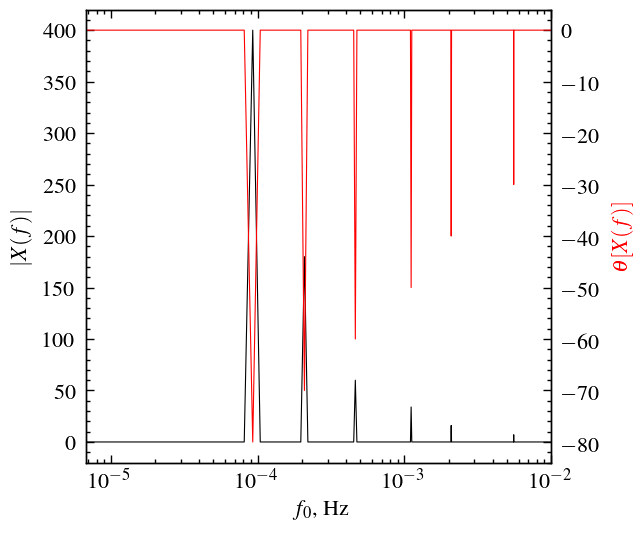

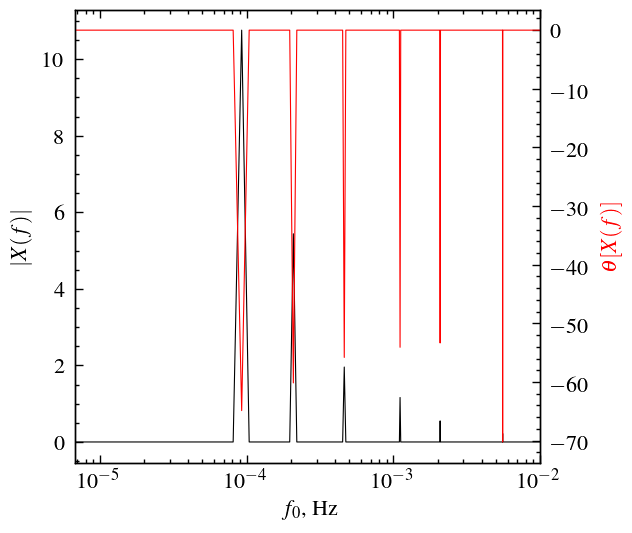

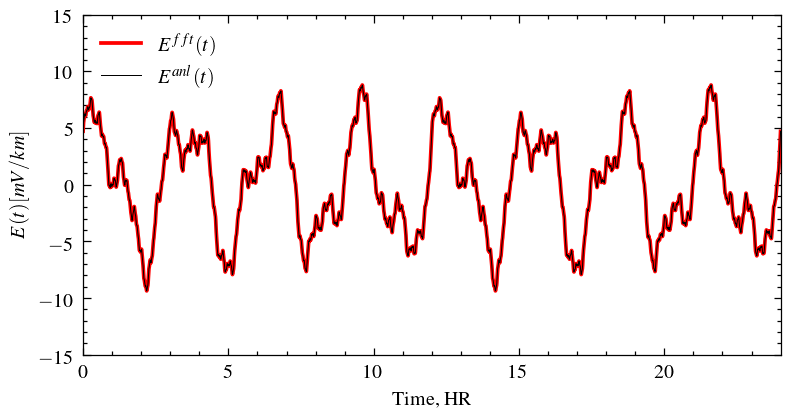

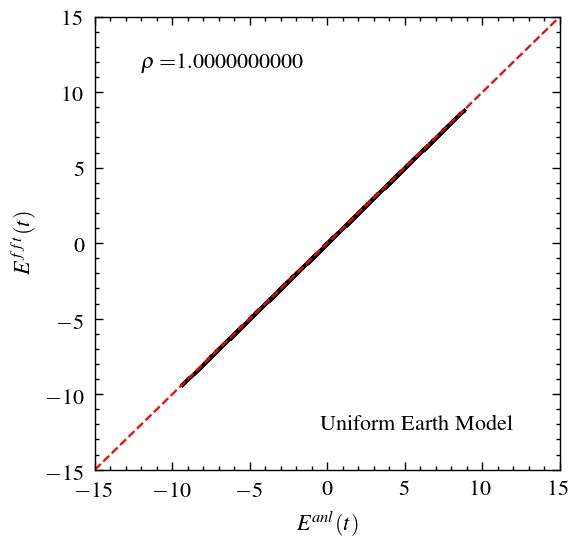

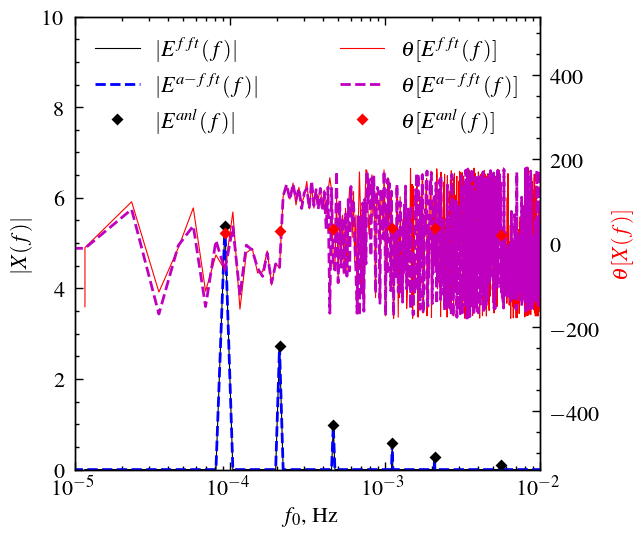

In [8]:
# Convert uniform Earth model
Ef_uniform, fa, Et_uniform, o_uni = calculate_electric_field(Bt, omu)
Ef_analytical_uniform, fb, Et_analytical_uniform, o_ana_uni = calculate_analytical_et(tfu)
fig = plt.figure(dpi=180, figsize=(5, 2.5))
ax = fig.add_subplot(111)
ax.plot(t0, Et_uniform, "r", lw=1.5, label=r"$E^{fft}(t)$")
ax.set_ylabel(r"$E(t)[mV/km]$")
ax.set_xlim(0, t0[-1])
ax.set_xlabel("Time, HR")
ax.plot(t0, Et_analytical_uniform, "k-", lw=0.4, label=r"$E^{anl}(t)$")
ax.set_ylabel(r"$E(t)[mV/km]$")
ax.legend(loc=2)
ax.set_xlim(0, t0[-1])
_ = ax.set_ylim(-15,15)

reg_check(Et_analytical_uniform, Et_uniform,"Uniform Earth Model")

print(o_uni)
print(o_ana_uni)


fig, ax = plt.subplots(figsize=(3,3), dpi=200)
ax.semilogx(fa, np.absolute(Ef_uniform), "k", lw=0.4, label=r"$|E^{fft}(f)|$")
ax.semilogx(fb, np.absolute(Ef_analytical_uniform), "b", lw=1.0, ls="--", label=r"$|E^{a-fft}(f)|$")
ax.semilogx(o_ana_uni["fm (Hz)"], o_ana_uni["Amplitude (mV/km)"], "kD", ms=2, label=r"$|E^{anl}(f)|$")
ax.legend(loc=2)
ax.set_xlim(1e-5, 1e-2)
ax.set_ylim(0,10)
ax.set_ylabel(r"$|X(f)|$")
ax.set_xlabel(r"$f_0$, Hz")
ax = ax.twinx()
ax.semilogx(fa, np.angle(Ef_uniform, deg=True), "r", lw=0.4, label=r"$\theta[E^{fft}(f)]$")
ax.semilogx(fb, np.angle(Ef_analytical_uniform, deg=True), "m", lw=1.0, ls="--", 
            label=r"$\theta[E^{a-fft}(f)]$")
ax.semilogx(o_ana_uni["fm (Hz)"], o_ana_uni["Phase, tm, (deg)"], "rD", ms=2, 
            label=r"$\theta[E^{anl}(f)]$")
ax.legend(loc=1)
ax.set_xlim(1e-5, 1e-2)
ax.set_ylim(-540,540)
_ = ax.set_ylabel(r"$\theta[X(f)]$", color="r")

/home/shibaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/shibaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/shibaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/shibaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


    fm (Hz)  Amplitude (mV/km)  Phase, tm, (deg)      real      imag
m                                                                   
0  0.000093           7.510369         18.880075  2.430268 -7.106295
1  0.000208           3.466266         23.091231  1.359457 -3.188554
2  0.000463           1.164689         28.812741  0.561320 -1.020500
3  0.001111           0.660879         32.743985  0.357460 -0.555863
4  0.002083           0.308472         35.011064  0.176981 -0.252651
5  0.005556           0.124263         19.817503  0.042128 -0.116904
    fm (Hz)  Amplitude (mV/km)  Phase, tm, (deg)
m                                               
0  0.000093           7.510369         18.880075
1  0.000208           3.466266         23.091231
2  0.000463           1.164689         28.812741
3  0.001111           0.660879         32.743985
4  0.002083           0.308472         35.011064
5  0.005556           0.124263         19.817503


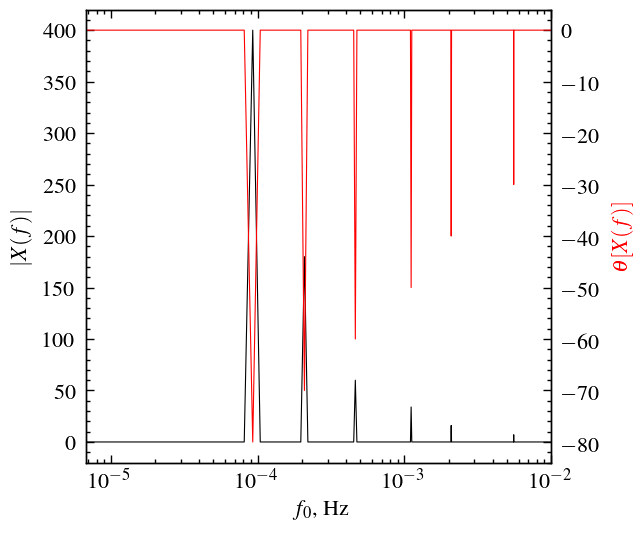

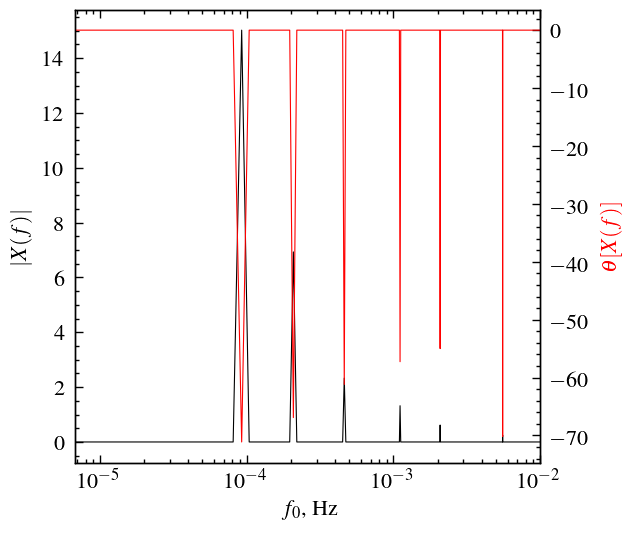

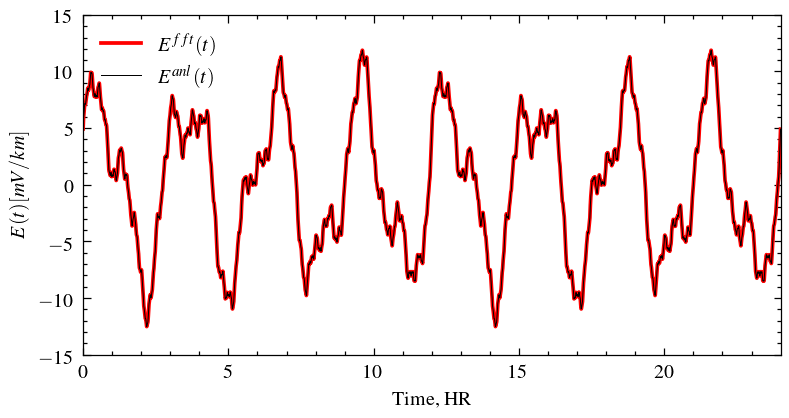

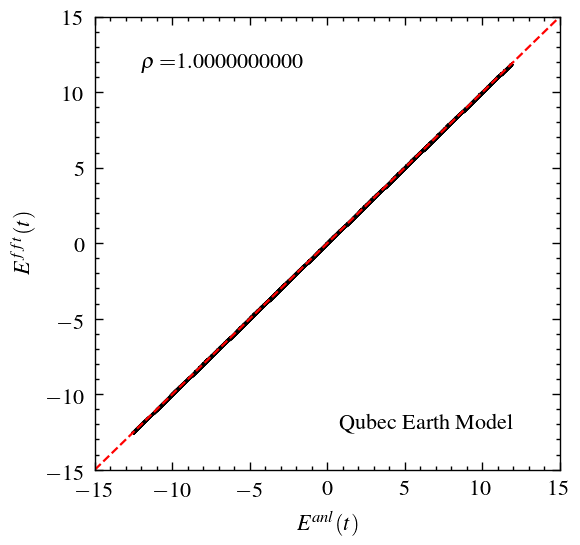

In [9]:
# Convert uniform Earth model
Ef_eh, fa, Et_eh, o_eh = calculate_electric_field(Bt, om)
Ef_analytical_eh, fb, Et_analytical_eh, o_ana_eh = calculate_analytical_et(tf)
fig = plt.figure(dpi=180, figsize=(5, 2.5))
ax = fig.add_subplot(111)
ax.plot(t0, Et_eh, "r", lw=1.5, label=r"$E^{fft}(t)$")
ax.set_ylabel(r"$E(t)[mV/km]$")
ax.set_xlim(0, t0[-1])
ax.set_xlabel("Time, HR")
ax.plot(t0, Et_analytical_eh, "k-", lw=0.4, label=r"$E^{anl}(t)$")
ax.set_ylabel(r"$E(t)[mV/km]$")
ax.legend(loc=2)
ax.set_xlim(0, t0[-1])
_ = ax.set_ylim(-15,15)

reg_check(Et_analytical_eh, Et_eh, "Qubec Earth Model")

print(o_eh)
print(o_ana_eh)